
# OCT Semantic Segmentation (6-Class) — UNet (TensorFlow/Keras)

**Classes:** `background, ILM, OPL, IS-OS, IBRPE, OBRPE`

Pipeline:
1) Data loading & exploration (OCT images: `oct_images/`, masks: `oct_masks/`)
2) Preprocessing & augmentation
3) UNet (6-channel softmax output)
4) Training (Sparse Categorical Crossentropy, MeanIoU)
5) Evaluation (per-class metrics, confusion matrix)
6) Visualization (colorized masks & overlays)


## 0. Environment & Reproducibility

In [1]:

import os, random, numpy as np, tensorflow as tf
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TensorFlow:", tf.__version__)


2025-10-04 21:38:46.793030: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-04 21:38:46.793241: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-04 21:38:46.830963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-04 21:38:47.637004: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow: 2.20.0


## 1. Configuration

In [ ]:

from pathlib import Path
DATA_DIR_IMAGES = Path("oct_images_grader3")
DATA_DIR_MASKS  = Path("oct_masks_grader3")  

IMG_HEIGHT = 512
IMG_WIDTH  = 512
IMG_CHANNELS = 1
N_CLASSES = 6
CLASS_NAMES = ["background", "ILM", "OPL", "IS-OS", "IBRPE", "OBRPE"]

BATCH_SIZE = 8
EPOCHS = 15
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
LEARNING_RATE = 1e-3

AUG_ROTATE = True
AUG_FLIP = True
AUG_BRIGHTNESS = True

OUT_DIR = Path("oct_seg_outputs_multiclass")
OUT_DIR.mkdir(parents=True, exist_ok=True)


## 2. Utilities (I/O, Palette, Visualization)

In [3]:

import cv2, json
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

PALETTE_MAP = None
DISPLAY_COLORS = np.array([[0,0,0],[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255]], dtype=np.uint8)

def read_image(path: Path, channels: int = 1) -> np.ndarray:
    if channels == 1:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None: raise FileNotFoundError(f"Failed to read image: {path}")
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255.0
        img = np.expand_dims(img, axis=-1)
    else:
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None: raise FileNotFoundError(f"Failed to read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255.0
    return img

def discover_palette(mask_paths: List[Path], max_scan=500) -> Dict[int,int]:
    vals = set()
    for p in mask_paths[:max_scan]:
        m = cv2.imread(str(p), cv2.IMREAD_COLOR)
        if m is None: continue
        g = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
        g = cv2.resize(g, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        vals.update(np.unique(g).tolist())
    vals = sorted(list(vals))
    mapping = {}
    if len(vals) != N_CLASSES:
        print(f"[WARN] Found {len(vals)} unique grayscale values, expected {N_CLASSES}. Values:", vals)
    for idx, v in enumerate(vals[:N_CLASSES]):
        mapping[int(v)] = int(idx)
    import pandas as pd
    df = pd.DataFrame({"grayscale_value": list(mapping.keys()),
                       "class_index": list(mapping.values()),
                       "class_name": [CLASS_NAMES[i] for i in mapping.values()]})
    df.to_csv(OUT_DIR/"palette_mapping.csv", index=False)
    print("Saved palette mapping to:", OUT_DIR/"palette_mapping.csv")
    return mapping

def read_mask_with_palette(path: Path) -> np.ndarray:
    global PALETTE_MAP
    m = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if m is None: raise FileNotFoundError(f"Failed to read mask: {path}")
    g = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    g = cv2.resize(g, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    if PALETTE_MAP is None: raise RuntimeError("PALETTE_MAP is not initialized")
    lut = np.zeros(256, dtype=np.int32)
    for k,v in PALETTE_MAP.items(): lut[int(k)] = int(v)
    labels = lut[g]
    return np.expand_dims(labels, axis=-1).astype(np.int32)

def colorize_labels(lbl_hw: np.ndarray) -> np.ndarray:
    rgb = np.zeros((lbl_hw.shape[0], lbl_hw.shape[1], 3), dtype=np.uint8)
    for i in range(N_CLASSES): rgb[lbl_hw==i] = DISPLAY_COLORS[i]
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    return rgb

def overlay_prediction(img: np.ndarray, pred_labels: np.ndarray, alpha=0.4) -> np.ndarray:
    base = np.dstack([img.squeeze()]*3) if img.shape[-1]==1 else img.copy()
    base = (base*255).astype(np.uint8)
    color = colorize_labels(pred_labels)
    return cv2.addWeighted(base, 1.0, color, alpha, 0)

def show_triplet(img, gt_labels, pred_labels=None, title="Sample"):
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1); plt.imshow(img.squeeze(), cmap="gray" if img.shape[-1]==1 else None); plt.title("Image"); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(colorize_labels(gt_labels.squeeze())); plt.title("GT"); plt.axis('off')
    if pred_labels is not None:
        plt.subplot(1,4,3); plt.imshow(colorize_labels(pred_labels.squeeze())); plt.title("Pred"); plt.axis('off')
        plt.subplot(1,4,4); plt.imshow(overlay_prediction(img, pred_labels.squeeze())); plt.title("Overlay"); plt.axis('off')
    plt.suptitle(title); plt.show()


## 3. Data Indexing & Palette Discovery

Found 1672 images and 1672 masks.
Paired: 1672 | Missing masks: 0 | Extra masks: 0
Saved palette mapping to: oct_seg_outputs_multiclass/palette_mapping.csv


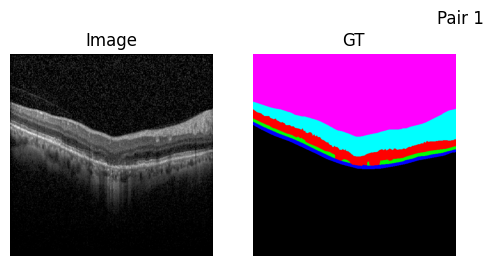

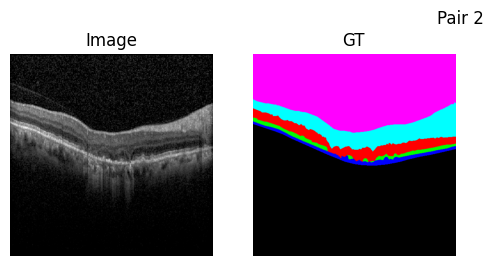

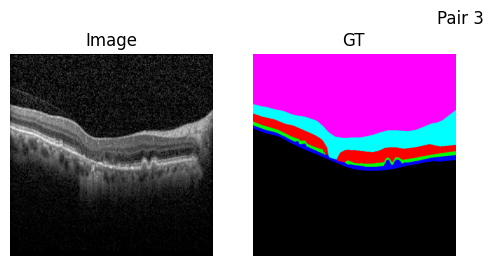

In [4]:

img_paths = sorted([p for p in DATA_DIR_IMAGES.rglob('*') if p.suffix.lower() in {'.png','.jpg','.jpeg','.tif','.tiff'}])
msk_paths = sorted([p for p in DATA_DIR_MASKS.rglob('*') if p.suffix.lower() in {'.png','.jpg','.jpeg','.tif','.tiff'}])
print(f"Found {len(img_paths)} images and {len(msk_paths)} masks.")

def stem(p: Path): return p.stem
img_dict = {stem(p): p for p in img_paths}
msk_dict = {stem(p): p for p in msk_paths}
pairs, missing_masks = [], []
for s, ip in img_dict.items():
    if s in msk_dict: pairs.append((ip, msk_dict[s]))
    else: missing_masks.append(ip)
extra_masks = [mp for s, mp in msk_dict.items() if s not in img_dict]
print(f"Paired: {len(pairs)} | Missing masks: {len(missing_masks)} | Extra masks: {len(extra_masks)}")

PALETTE_MAP = discover_palette([mp for _, mp in pairs])

for i in range(min(3, len(pairs))):
    img = read_image(pairs[i][0], IMG_CHANNELS)
    lab = read_mask_with_palette(pairs[i][1]).squeeze()
    show_triplet(img, lab, title=f"Pair {i+1}")


## 4. Train/Validation/Test Split

In [5]:

import numpy as np
rng = np.random.RandomState(SEED); rng.shuffle(pairs)
n = len(pairs); n_test = int(round(TEST_SPLIT*n)); n_val = int(round(VAL_SPLIT*n)); n_train = n - n_test - n_val
train_pairs = pairs[:n_train]; val_pairs = pairs[n_train:n_train+n_val]; test_pairs = pairs[n_train+n_val:]
print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")


Train: 1170, Val: 251, Test: 251


## 5. Data Pipeline (`tf.data`) with Augmentation

In [6]:

import tensorflow as tf

def _load_pair_py(img_path, msk_path):
    img = read_image(Path(img_path.decode()), IMG_CHANNELS)
    lab = read_mask_with_palette(Path(msk_path.decode()))
    return img, lab

def _load_pair(img_path, msk_path):
    img, lab = tf.numpy_function(_load_pair_py, [img_path, msk_path], [tf.float32, tf.int32])
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    lab.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    return img, lab

def _augment(img, lab):
    if AUG_FLIP:
        cond = tf.less(tf.random.uniform([],0,1.0), 0.5)
        img = tf.cond(cond, lambda: tf.image.flip_left_right(img), lambda: img)
        lab = tf.cond(cond, lambda: tf.image.flip_left_right(lab), lambda: lab)
    if AUG_ROTATE:
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        img = tf.image.rot90(img, k); lab = tf.image.rot90(lab, k)
    if AUG_BRIGHTNESS and IMG_CHANNELS == 1:
        img3 = tf.repeat(img, 3, axis=-1)
        img3 = tf.image.random_brightness(img3, max_delta=0.08)
        img = tf.reduce_mean(img3, axis=-1, keepdims=True)
    elif AUG_BRIGHTNESS and IMG_CHANNELS == 3:
        img = tf.image.random_brightness(img, max_delta=0.08)
    return img, lab

def make_ds(pairs, batch_size, training=False, shuffle=True):
    img_paths = [str(p[0]) for p in pairs]; msk_paths = [str(p[1]) for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_paths, msk_paths))
    if shuffle and training: ds = ds.shuffle(buffer_size=len(pairs), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    if training: ds = ds.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_pairs, BATCH_SIZE, training=True)
val_ds   = make_ds(val_pairs,   BATCH_SIZE, training=False, shuffle=False)
test_ds  = make_ds(test_pairs,  BATCH_SIZE, training=False, shuffle=False)

for x,y in train_ds.take(1):
    print("Batch shapes:", x.shape, y.shape, "| y min/max:", tf.reduce_min(y).numpy(), tf.reduce_max(y).numpy())


E0000 00:00:1759603130.453026 1529702 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759603130.480630 1529702 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Batch shapes: (8, 512, 512, 1) (8, 512, 512, 1) | y min/max: 0 5


2025-10-04 21:38:50.780507: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-10-04 21:38:50.850833: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 6. UNet Model (6-class softmax)

In [7]:

from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(img_h=256, img_w=256, img_c=1, base_filters=32, n_classes=6):
    inputs = layers.Input((img_h, img_w, img_c))
    c1, p1 = encoder_block(inputs, base_filters)
    c2, p2 = encoder_block(p1, base_filters*2)
    c3, p3 = encoder_block(p2, base_filters*4)
    c4, p4 = encoder_block(p3, base_filters*8)
    bn = conv_block(p4, base_filters*16)
    d1 = decoder_block(bn, c4, base_filters*8)
    d2 = decoder_block(d1, c3, base_filters*4)
    d3 = decoder_block(d2, c2, base_filters*2)
    d4 = decoder_block(d3, c1, base_filters)
    outputs = layers.Conv2D(n_classes, 1, activation="softmax")(d4)
    return models.Model(inputs, outputs, name="UNet_OCT_6class")

model = build_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, base_filters=32, n_classes=N_CLASSES)
model.summary()


Model: "UNet_OCT_6class"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]  

 Total params: 7,771,462 (29.65 MB)

 Trainable params: 7,765,574 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

#/home/hamada/OCT5k/OCT_SEG_New_Start/OCT5k/Curated_images_masks/OCT_Segmentation_6Class_Pipeline.ipynb

## 7. Compile & Train

In [8]:

class ArgmaxMeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

mean_iou_metric = ArgmaxMeanIoU(num_classes=N_CLASSES)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy", mean_iou_metric])

ckpt_path = str(OUT_DIR/"best_unet_weights_6class.weights.h5")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", mode="max",
                                       save_best_only=True, save_weights_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
model.save(OUT_DIR/"final_unet_model_6class.keras")
print("Saved:", OUT_DIR/"final_unet_model_6class.keras")


Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6868 - argmax_mean_io_u: 0.2849 - loss: 0.9317
Epoch 1: val_accuracy improved from None to 0.52639, saving model to oct_seg_outputs_multiclass/best_unet_weights_6class.weights.h5
147/147 ━━━━━━━━━━━━━━━━━━━━ 982s 7s/step - accuracy: 0.7455 - argmax_mean_io_u: 0.3526 - loss: 0.7281 - val_accuracy: 0.5264 - val_argmax_mean_io_u: 0.0877 - val_loss: 12.7694 - learning_rate: 0.0010
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8547 - argmax_mean_io_u: 0.5476 - loss: 0.4149
Epoch 2: val_accuracy did not improve from 0.52639
147/147 ━━━━━━━━━━━━━━━━━━━━ 976s 7s/step - accuracy: 0.8694 - argmax_mean_io_u: 0.5771 - loss: 0.3762 - val_accuracy: 0.2510 - val_argmax_mean_io_u: 0.0427 - val_loss: 3.7634 - learning_rate: 0.0010
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9108 - argmax_mean_io_u: 0.6768 - loss: 0.2640
Epoch 3: val_accuracy improved from 0.52639 to 0.52915, saving model to oct_seg_

## 8. Training History Plots

History keys: ['accuracy', 'argmax_mean_io_u', 'loss', 'val_accuracy', 'val_argmax_mean_io_u', 'val_loss', 'learning_rate']


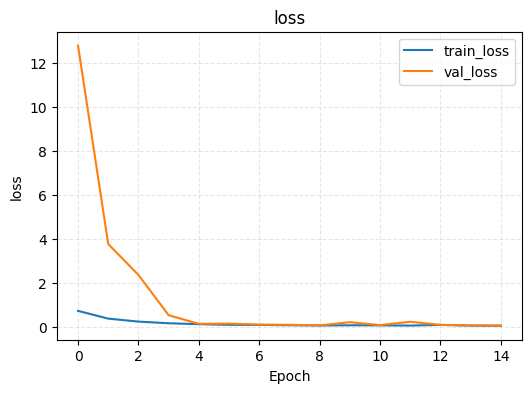

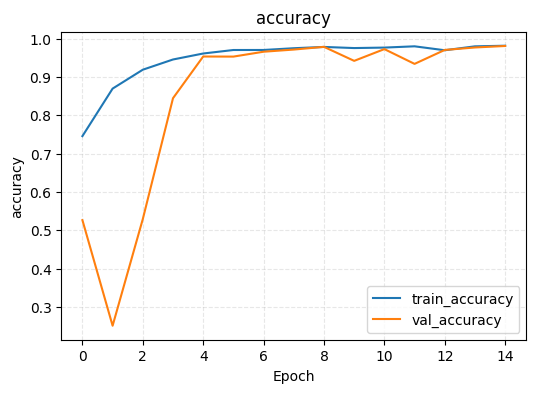

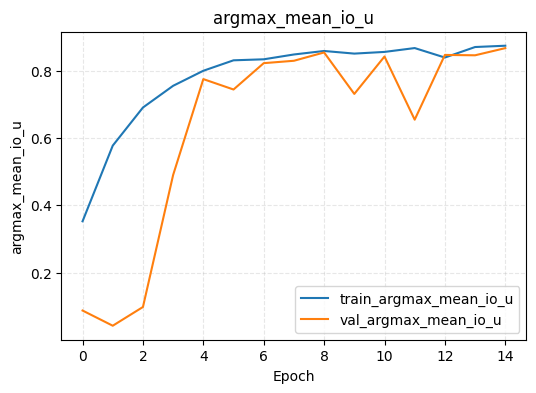

In [9]:

import matplotlib.pyplot as plt
print("History keys:", list(history.history.keys()))
def plot_history(h, keys=("loss","accuracy","argmax_mean_io_u")):
    for k in keys:
        if k in h.history:
            plt.figure(figsize=(6,4))
            plt.plot(h.history[k], label=f"train_{k}")
            vk = f"val_{k}"
            if vk in h.history: plt.plot(h.history[vk], label=f"val_{k}")
            plt.xlabel("Epoch"); plt.ylabel(k); plt.title(k); plt.legend(); plt.grid(True, ls="--", alpha=0.3); plt.show()
plot_history(history)


## 9. Evaluation on Test Set

In [10]:
%pwd

'/home/hamada/OCT5k/OCT_SEG_New_Start/OCT5k/Curated_images_masks'

In [ ]:

best_model = build_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, base_filters=32, n_classes=N_CLASSES)
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics=["accuracy", ArgmaxMeanIoU(num_classes=N_CLASSES)])
best_model.load_weights(OUT_DIR/"best_unet_weights_6class.weights.h5")  #OCT5k/Curated_images_masks/oct_seg_outputs_multiclass/best_unet_weights_6class.weights.h5
test_metrics = best_model.evaluate(test_ds, verbose=1)
dict(zip(best_model.metrics_names, [float(x) for x in test_metrics]))


## 10. Predictions & Visualization

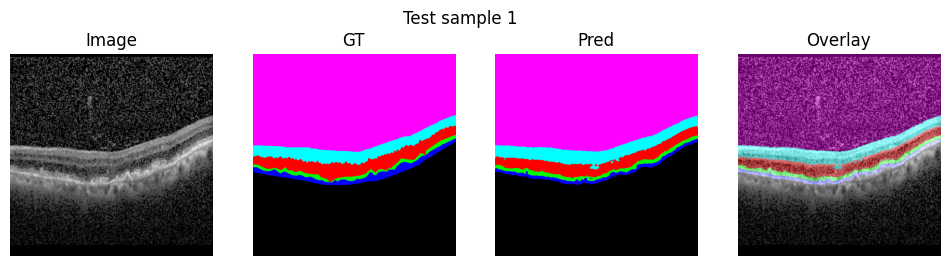

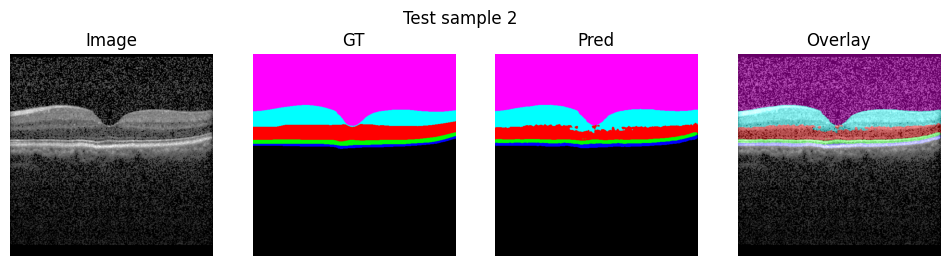

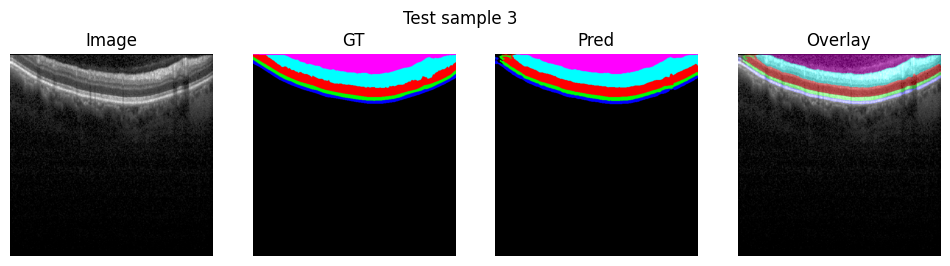

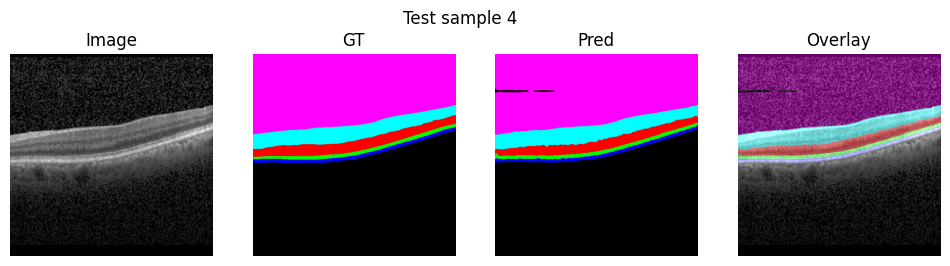

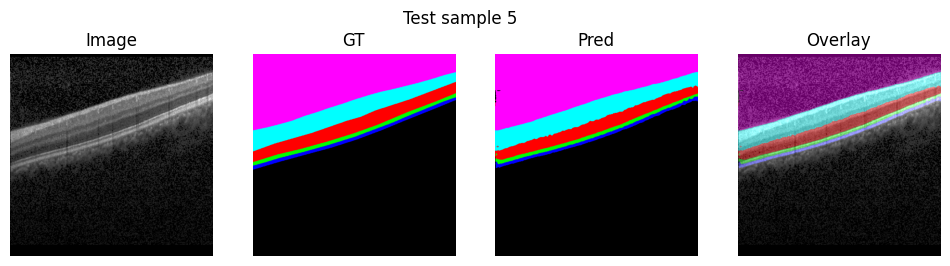

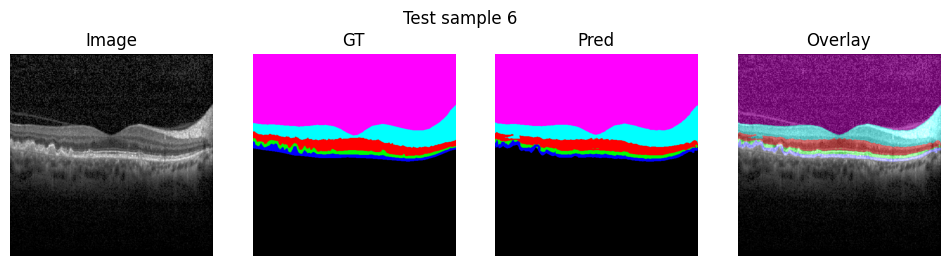

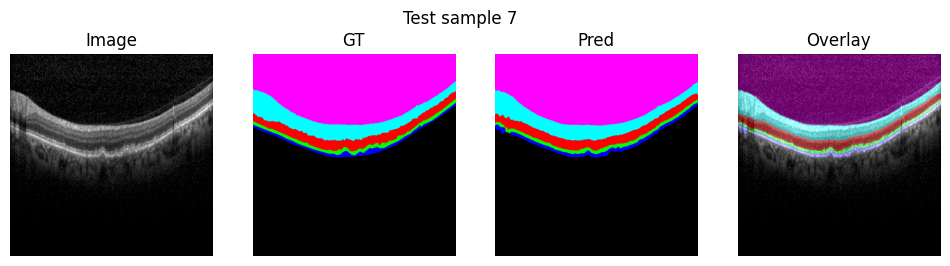

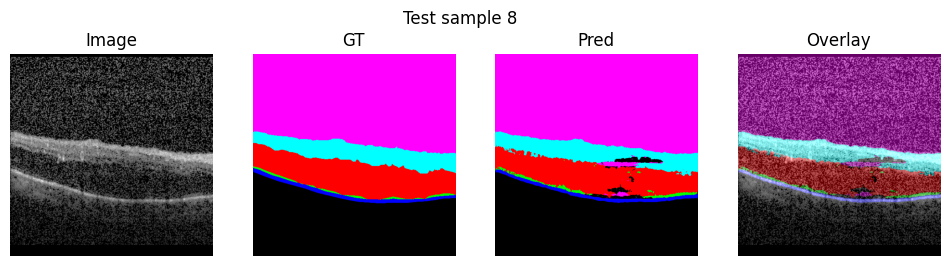

In [12]:

import numpy as np, matplotlib.pyplot as plt

def predict_and_visualize(ds, samples=8):
    xs, ys = next(iter(ds))
    preds = best_model.predict(xs, verbose=0)
    preds_lab = np.argmax(preds, axis=-1).astype(np.int32)
    n = min(samples, xs.shape[0])
    for i in range(n):
        img = xs[i].numpy(); gt = ys[i].numpy().squeeze(); pr = preds_lab[i]
        show_triplet(img, gt, pr, title=f"Test sample {i+1}")
predict_and_visualize(test_ds, samples=8)


## 11. Per-Class Metrics & Confusion Matrix

In [13]:

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd, numpy as np

y_true_all, y_pred_all = [], []
for xs, ys in test_ds:
    ps = best_model.predict(xs, verbose=0)
    y_pred = np.argmax(ps, axis=-1).astype(np.int32)
    y_true = ys.numpy().squeeze(-1).astype(np.int32)
    y_true_all.append(y_true); y_pred_all.append(y_pred)
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

yt = y_true_all.flatten(); yp = y_pred_all.flatten()
labels = list(range(N_CLASSES))
cm = confusion_matrix(yt, yp, labels=labels)
print("Confusion matrix:\n", cm)

precision, recall, f1, support = precision_recall_fscore_support(yt, yp, labels=labels, zero_division=0)

ious, dices = [], []
for c in labels:
    tp = cm[c,c]; fp = cm[:,c].sum()-tp; fn = cm[c,:].sum()-tp
    iou = tp / (tp + fp + fn + 1e-9)
    dice = (2*tp) / (2*tp + fp + fn + 1e-9)
    ious.append(iou); dices.append(dice)

metrics_df = pd.DataFrame({
    "class_index": labels,
    "class_name": [CLASS_NAMES[i] for i in labels],
    "precision": precision, "recall": recall, "f1": f1,
    "iou": ious, "dice": dices, "support": support
})
metrics_df.to_csv(OUT_DIR/"test_per_class_metrics.csv", index=False)
metrics_df


2025-10-05 01:40:50.298202: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix:
 [[34888888    31014      987     1061      202     1084]
 [  141144   875810    35302     1586      470      238]
 [    6099   117404   922419    27937      989      446]
 [    8470     2680   107238  3193202   199332     5967]
 [    2392      246      238    88968  4693965    61134]
 [  117448        0        0      444    64060 20199280]]


,class_index,class_name,precision,recall,f1,iou,dice,support
0,0,background,0.992164,0.999016,0.995578,0.991196,0.995578,34923236
1,1,ILM,0.852657,0.830506,0.841436,0.726274,0.841436,1054550
2,2,OPL,0.865159,0.857830,0.861479,0.756665,0.861479,1075294
3,3,IS-OS,0.963782,0.907962,0.935040,0.878005,0.935040,3516889
4,4,IBRPE,0.946551,0.968438,0.957370,0.918225,0.957370,4846943
5,5,OBRPE,0.996602,0.991073,0.993830,0.987735,0.993830,20381232
